# Session 3 - Train a REGRESSION Model

## SETUP

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ‚â•0.20.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ‚â•3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ‚â•0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Linear Regression

**Linear regression** is a fundamental and widely-used statistical technique for modeling the relationship between a dependent variable (**y**) and one or more independent variables (**x‚ÇÅ, x‚ÇÇ, ..., x‚Çö**). It is used primarily for regression problems where the goal is to predict a continuous target variable.

### Key Assumption:
Linear regression assumes a **linear relationship** between the target variable **y** and the input features **x‚ÇÅ, x‚ÇÇ, ..., x‚Çö**. The general form of the linear regression model is:

$
y = b_0 + b_1x_1 + b_2x_2 + \dots + b_p x_p
$

where:
- **$y$** is the predicted value (dependent variable),
- **$b_0$** is the intercept (bias term),
- **$b_1, b_2, ..., b_p$** are the coefficients (weights) corresponding to each feature **$x_1, x_2, ..., x_p$** (independent variables),
- **$p$** is the number of features.

### Pros of Linear Regression:
- **Widely used**: Linear regression is a popular technique, well understood, and applied in many fields.
- **Runs fast**: It is computationally efficient, especially for smaller datasets, making it suitable for real-time applications.
- **Easy to use**: Linear regression requires minimal hyperparameter tuning compared to more complex machine learning models.
- **Highly interpretable**: The simplicity of the model makes it easy to interpret; the coefficients **$b_1, b_2, ..., b_p$** directly indicate the impact of each feature on the target variable.
- **Foundation for other methods**: Linear regression forms the basis for more advanced methods such as Ridge and Lasso regression, logistic regression, and generalized linear models.


In [2]:
# Let's create some data to ilustrate the problem
m = 20 # number of instances
X = 2 * np.random.rand(m, 1)  # column vector; input features
y = 4 + 3 * X + 2*np.random.randn(m, 1)  # column vector; target values

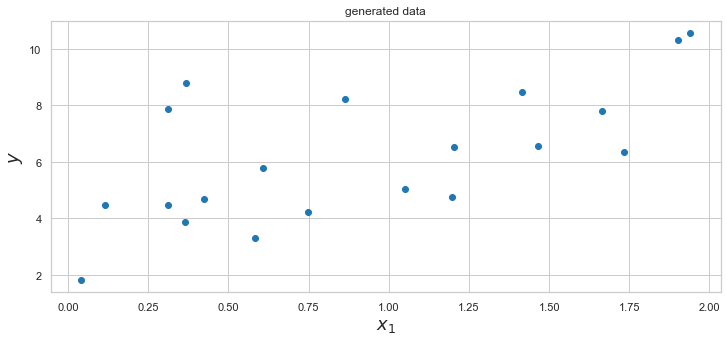

In [3]:
plt.plot(X,y,"o")
plt.xlabel("$x_1 $", fontsize=18)
plt.ylabel("$y $", rotation=90, fontsize=18)
plt.title('generated data')
plt.show()

## How to minimize the OLS cost funciton?

### Ordinary Least Squares (OLS)

The **Ordinary Least Squares (OLS)** method is a widely used **estimator** in linear regression, particularly effective for multiple linear regression where there are two or more independent variables. The goal of OLS is to choose the parameters **$\mathbf{b}$** to minimize the sum of squared differences between the predicted values and the actual target values.

For a given set of samples **$(\mathbf{X}, \mathbf{y})$**, the linear model can be expressed as:

$$
\mathbf{y} = \mathbf{X} \mathbf{b}
$$

where:
- **$\mathbf{y} = [y_1, y_2, \ldots, y_n]^T$** represents the actual target values,
- **$\mathbf{X}$** is the design matrix, which includes a column of ones for the intercept and the feature values: 

$$
\mathbf{X} = \begin{pmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1p} \\
1 & x_{21} & x_{22} & \cdots & x_{2p} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{n1} & x_{n2} & \cdots & x_{np}
\end{pmatrix}
$$

- **$\mathbf{b} = [b_0, b_1, b_2, \ldots, b_p]^T$** is the vector of coefficients, where **$b_0$** is the intercept and **$b_1, b_2, \ldots, b_p$** are the coefficients for each feature.

#### Objective of OLS
The objective of OLS is to minimize the sum of squared residuals (the differences between the actual values and predicted values) by optimizing **$\mathbf{b}$**. This can be mathematically expressed as:

$$
\min_{\mathbf{b}} \; ||\mathbf{X} \mathbf{b} - \mathbf{y}||^2_2 = \sum_{j=1}^n (y_j - \hat{y}_j)^2
$$

where **$\hat{y}_j = \mathbf{X}_j \mathbf{b}$** is the predicted value for the \(j\)-th observation.

#### Explanation
- **$n$** is the number of data points (observations).
- The expression $||\mathbf{X} \mathbf{b} - \mathbf{y}||^2_2$ represents the **sum of squared errors (SSE)** or **sum of squared residuals**.

Minimizing this expression provides the optimal values for the coefficients in the OLS framework, allowing for the best linear approximation of the relationship between the dependent variable and multiple independent variables.


### Linear regression using the Normal Equation

The **Normal Equation** provides a direct, closed-form solution to the linear regression problem. It calculates the optimal parameters that minimize the cost function without the need for iterative methods such as Gradient Descent.

The Normal Equation is expressed as:

$$\theta = (X^TX)^{-1}X^Ty$$

where:
- **$\theta$** is the parameter vector that minimizes the cost function (also called the vector of regression coefficients).
- **$X$** is the design matrix (matrix of input features), where each row represents a training example, and each column represents a feature (with an additional bias feature of 1 if the intercept term is included).
- **$y$** is the vector of target values (dependent variable) corresponding to each training example.

#### Notes:
1. **$X^T$** denotes the transpose of matrix $X$.
2. **$(X^TX)^{-1}$** is the inverse of the matrix $X^TX$. The matrix $X^TX$ must be invertible (nonsingular), which can be a problem if $X$ is not of full rank (i.e., when features are linearly dependent). In such cases, the normal equation might not provide a unique solution.
3. This method is generally not preferred for very large datasets, as computing the inverse of a matrix has a time complexity of $\mathcal{O}(n^3)$, where $n$ is the number of features. Instead, methods like Gradient Descent are often used for large-scale problems.


In [4]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
b0,b1 = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
print(b0,b1)

[3.92721001] [2.48346527]


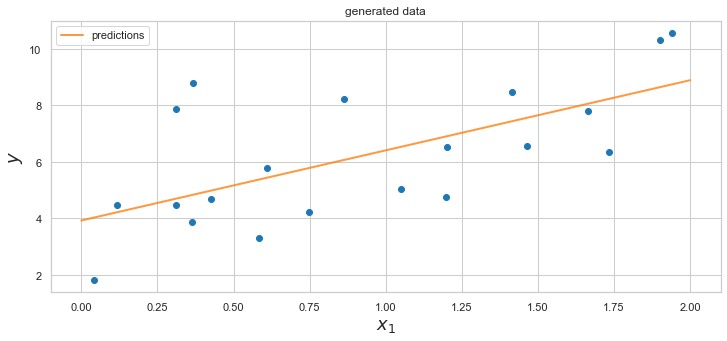

In [5]:
plt.plot(X,y,"o")
plt.xlabel("$x_1 $", fontsize=18)
plt.ylabel("$y $", rotation=90, fontsize=18)
plt.plot([0,2], [b0, b0+b1*2], alpha=0.8, label = 'predictions') # Add the regression line, colored in blue
plt.title('generated data')
plt.legend(loc="upper left")
plt.show()

### How to compute the OLS: Scipy.optimize

In [6]:
# To understand the use of zip in the next code:
list(zip([2,3,4,5,6],[40,50,60,70,80]))

[(2, 40), (3, 50), (4, 60), (5, 70), (6, 80)]

Optimization terminated successfully.
         Current function value: 62.032746
         Iterations: 77
         Function evaluations: 142


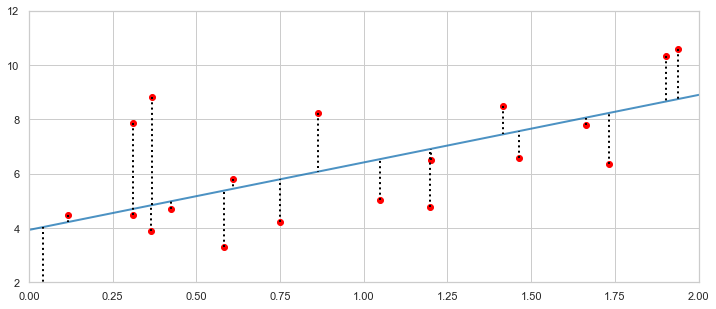

In [7]:
from scipy.optimize import fmin

# Minimize the sum of squares using a lambda function

sse = lambda b, x, y: np.sum((y - b[0] - b[1]*x) ** 2) # Store the sum of squared differences function
# Lambda function is a small anonymous function. 
# It can take any number of arguments, but can only have one expression. 
# Syntax "lambda arguments : expression"

b0,b1 = fmin(sse, [0,1], args=(X,y)); # Minimize the sum of squared differences
# [0,1] is the initial guess for w[0] and w[1] in function sse.

plt.plot(X, y, 'ro')
plt.plot([0,10], [b0, b0+b1*10], alpha=0.8) # Add the regression line, colored in blue
for xi, yi in zip(X,y):
    plt.plot([xi]*2, [yi, b0+b1*xi], "k:") # Add pointed black line to illustrate the errors
plt.xlim(0, 2); plt.ylim(2, 12) # Restrict the domain
plt.show()

Instead of using the OLS we can minimize other criteria, such as the **sum of absolute differences between the predicted values and the actual values**. 

Optimization terminated successfully.
         Current function value: 27.934797
         Iterations: 106
         Function evaluations: 201


(2.0, 12.0)

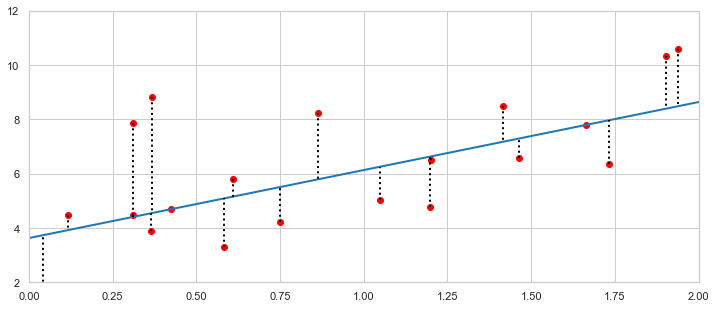

In [8]:
sabs = lambda b, x, y: np.sum(np.abs(y - b[0] - b[1]*x)) # Lambda function 

b0,b1 = fmin(sabs, [0,1], args=(X,y)) # Minimize the sum of absolute differences
plt.plot(X, y, 'ro')
plt.plot([0,10], [b0, b0+b1*10]) # Add the regression line, colored in blue
for xi, yi in zip(X,y):
    plt.plot([xi]*2, [yi, b0+b1*xi], "k:") # Add pointed black line to illustrate the errors
plt.xlim(0, 2); plt.ylim(2, 12) # Restrict the domain

##¬†Example 1: Adversiting dataset


Let's play with an Adversiting dataset from the book "Introduction to Statistical Learning"

**The Data** 

A data frame with 200 observations on the following 4 variables (TV ,Radio, Newspaper, Sales)

In [68]:
df = pd.read_csv('https://raw.githubusercontent.com/justmarkham/scikit-learn-videos/master/data/Advertising.csv',index_col=0)
df.head()

TV  Radio  Newspaper  Sales
1  230.1   37.8       69.2   22.1
2   44.5   39.3       45.1   10.4
3   17.2   45.9       69.3    9.3
4  151.5   41.3       58.5   18.5
5  180.8   10.8       58.4   12.9

In [69]:
print(df.shape)

(200, 4)


What are the features?

* TV: advertising dollars spent on TV for a single product in a given market (in thousands of dollars)
* Radio: advertising dollars spent on Radio
* Newspaper: advertising dollars spent on Newspaper

What is the response?

* Sales: sales of a single product in a given market (in thousands of items)

What else do we know?

Because the response variable is continuous, this is a regression problem.
There are 200 observations (represented by the rows), and each observation is a single market

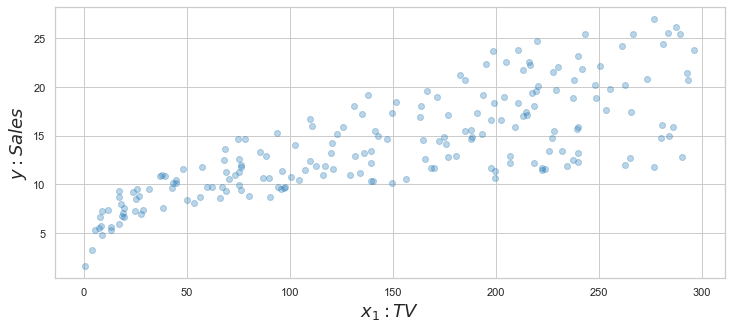

In [70]:
X = df[['TV']]
y = df[['Sales']]
plt.plot(X,y,"o", alpha=0.3)
plt.xlabel("$x_1 : TV$", fontsize=18)
plt.ylabel("$y : Sales$", rotation=90, fontsize=18)
plt.show()

In [71]:
#X_b = np.c_[np.ones((200, 1)), X]  # add x0 = 1 to each instance
X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [72]:
theta_best

array([[7.03259355],
       [0.04753664]])

In [73]:
X_new = np.array([[0], [300]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 7.03259355],
       [21.29358568]])

The figure in the book actually corresponds to the following code, with a legend and axis labels:

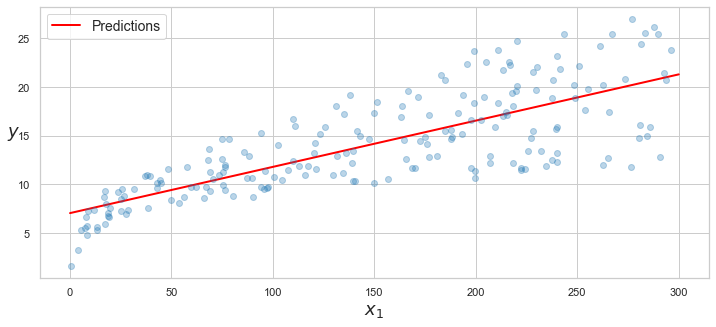

In [74]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "o",alpha=0.3)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.show()

In [75]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([7.03259355]), array([[0.04753664]]))

In [76]:
lin_reg.predict(X_new)

/Users/santisegui/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[ 7.03259355],
       [21.29358568]])

As you can see, in this case, far values are penalized less.

### Linear Regression using Statsmodel package

In [18]:
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats
model = smf.ols(formula='Sales ~ TV', data=df)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Fri, 04 Oct 2024   Prob (F-statistic):           1.47e-42
Time:                        14:58:05   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.0

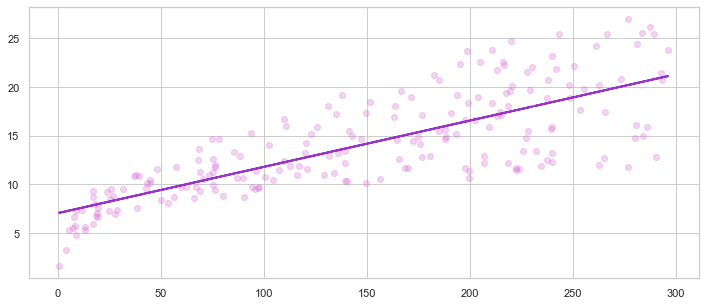

In [19]:

y_pred = model.predict(X)
plt.scatter(X, y, alpha=0.3, color='orchid')
plt.plot(X, y_pred, '-', color='darkorchid', linewidth=2)
plt.show()

### Linear Regression using SciKitLearn package

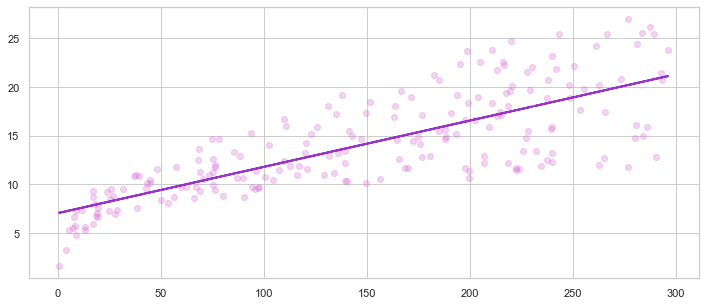

Coefficients: 
 [[0.04753664]]
Mean squared error: 10.513
Coefficient of determination (R^2): 0.612


In [20]:
from sklearn import linear_model

from sklearn.metrics import mean_squared_error, r2_score


lin_reg = linear_model.LinearRegression()
lin_reg.fit(X, y)

y_pred = lin_reg.predict(X)
# plot the output

# Plot outputs
plt.scatter(X, y, alpha=0.3, color='orchid')
plt.plot(X, y_pred, '-', color='darkorchid', linewidth=2)
plt.show()


# The coefficients
print('Coefficients: \n', lin_reg.coef_)
# The mean squared error
print('Mean squared error: %.3f'
      % mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination (R^2): %.3f'
      % r2_score(y, y_pred))

## Multiple Linear Regression
Simple linear regression can easily be extended to include multiple features. This is called multiple linear regression:

$$ Y = \beta_0 + \beta_1X_1 + ... \beta_pX_p + \epsilon $$

We interpret $\beta_j$ as the average effect on $Y$ of a one unit increase in $X_j$ , holding all other predictors fixed. In the advertising example, the model becomes:

$$ {\color{red}{sales}} = \beta_0 + \beta_1 ~x~ {\color{red}{TV}} + \beta_2 ~x~ {\color{red}{radio}} + \beta_3 ~x~ {\color{red}{newspaper}} + \epsilon $$

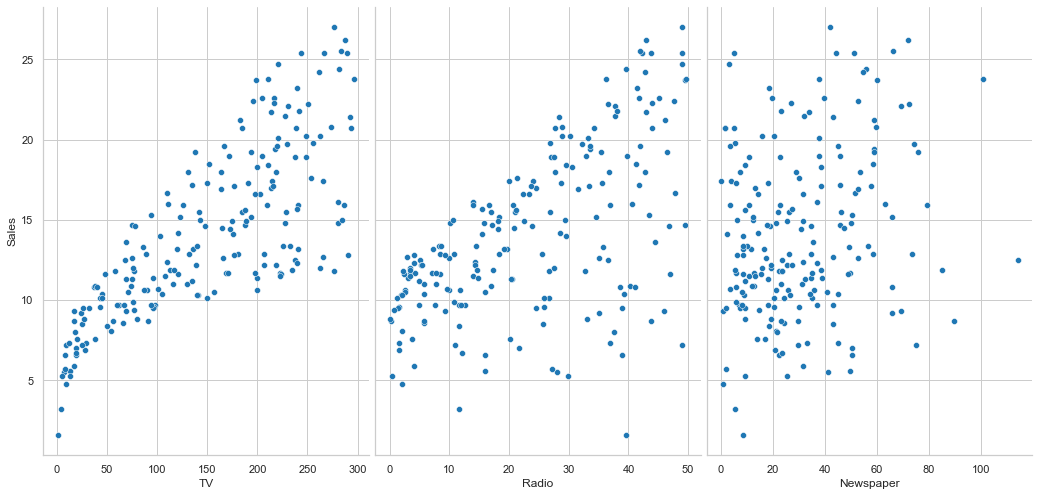

In [21]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(df, x_vars=['TV','Radio','Newspaper'],y_vars='Sales', height=7, aspect=0.7)
plt.show()

In [22]:
## with statsmodel
model = smf.ols(formula='Sales ~ TV + Radio', data=df)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Fri, 04 Oct 2024   Prob (F-statistic):           4.83e-98
Time:                        14:58:06   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                             778.4
Df Residuals:                     197   BIC:                             788.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9211      0.294      9.919      0.0

In [23]:
features = ['TV','Radio','Newspaper']
lin_reg = LinearRegression()
lin_reg.fit(df[features], y)

y_pred = lin_reg.predict(df[features])

# The coefficients
print('Coefficients: \n', lin_reg.coef_)
# The mean squared error
print('Mean squared error: %.3f'
      % mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination (R^2): %.3f'
      % r2_score(y, y_pred))

Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]
Mean squared error: 2.784
Coefficient of determination (R^2): 0.897


We can see how the Coefficient of determination (R^2) has improved from 0.612 to 0.897

In [24]:
corrMatrix = df.corr()
print (corrMatrix)

                 TV     Radio  Newspaper     Sales
TV         1.000000  0.054809   0.056648  0.782224
Radio      0.054809  1.000000   0.354104  0.576223
Newspaper  0.056648  0.354104   1.000000  0.228299
Sales      0.782224  0.576223   0.228299  1.000000


## Example 2:  Macroeconomic dataset

To start with we load the Longley dataset of US macroeconomic data from the R datasets website.

In [25]:
import pandas as pd
# Read data
df = pd.read_csv('http://vincentarelbundock.github.io/Rdatasets/csv/datasets/longley.csv', index_col=0)
df.columns = ['GNPdeflator', 'GNP', 'Unemployed', 'ArmedForces', 'Population','Year', 'Employed']
df.head()

GNPdeflator      GNP  Unemployed  ArmedForces  Population  Year  \
rownames                                                                    
1947             83.0  234.289       235.6        159.0     107.608  1947   
1948             88.5  259.426       232.5        145.6     108.632  1948   
1949             88.2  258.054       368.2        161.6     109.773  1949   
1950             89.5  284.599       335.1        165.0     110.929  1950   
1951             96.2  328.975       209.9        309.9     112.075  1951   

          Employed  
rownames            
1947        60.323  
1948        61.122  
1949        60.171  
1950        61.187  
1951        63.221

In [26]:
print(df.shape)

(16, 7)


Macroeconomic data from 1947 to 1962.

We will use the variable Total Derived Employment ('Employed') as our response $\textbf{y}$ and Gross National Product ('GNP') as our predictor $\textbf{x}$.

We also add a constant term so that we fit the intercept of our linear model: $X=(\textbf{1},\textbf{x})$

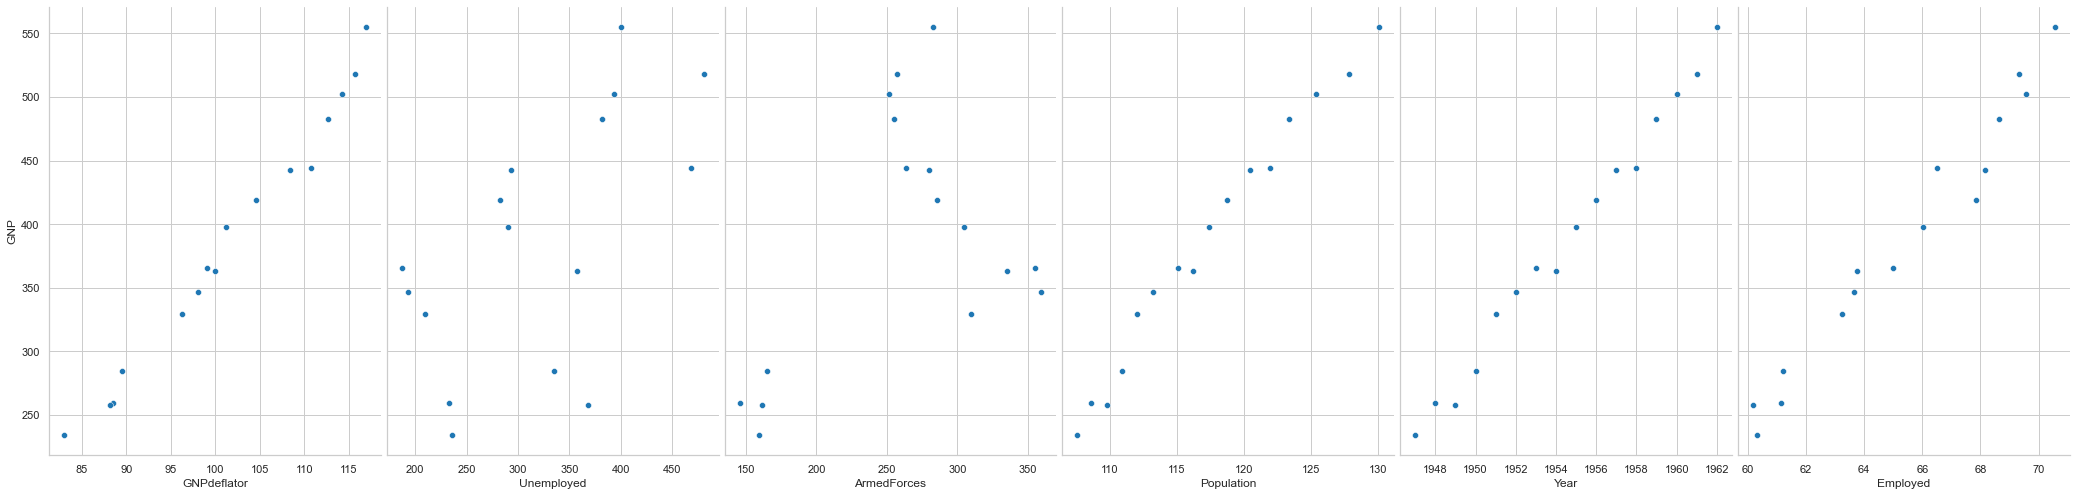

In [27]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(df, x_vars=['GNPdeflator','Unemployed','ArmedForces','Population','Year','Employed'],y_vars='GNP', height=7, aspect=0.7)
plt.show()

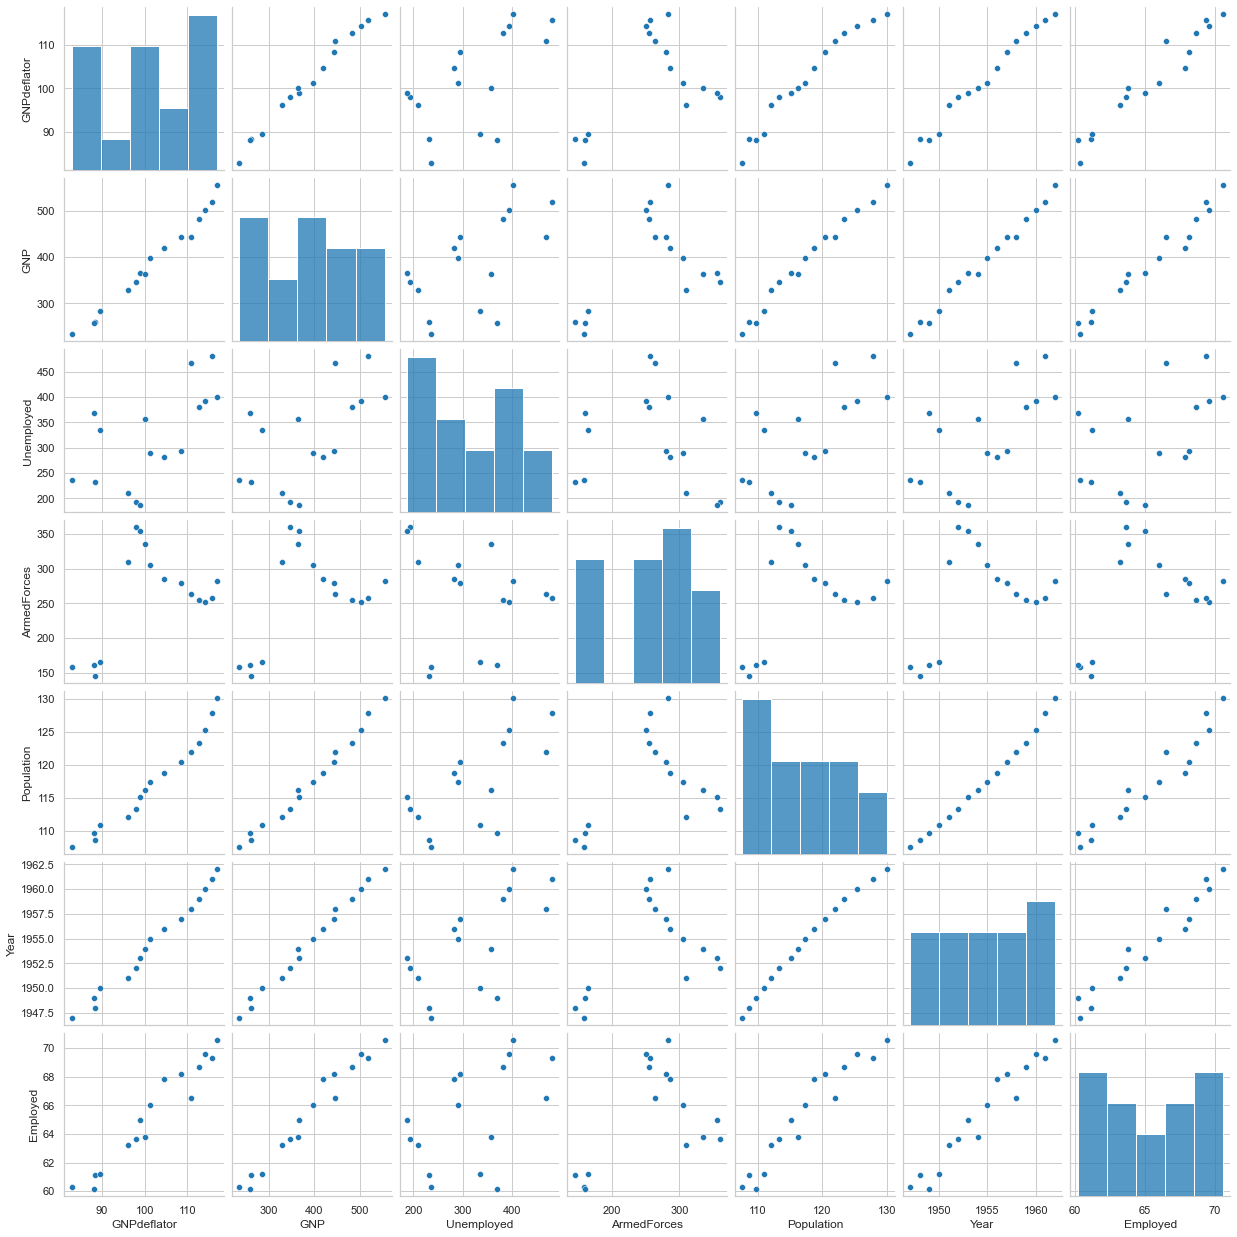

In [28]:
# another interesting graph from seaborn
sns.pairplot(df)
plt.show()

Let's create a model

In [29]:
## with sciklearn
features = ['GNPdeflator','Unemployed','ArmedForces','Population','Year','Employed']
target = ['GNP']

X = df[features]
y = df[target]

lin_reg = LinearRegression()
lin_reg.fit(X, y)

y_pred = lin_reg.predict(X)

# The coefficients
print('Coefficients: \n', lin_reg.coef_)
# The mean squared error
print('Mean squared error: %.3f'
      % mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination (R^2): %.3f'
      % r2_score(y, y_pred))

Coefficients: 
 [[ 1.50831401 -0.18594796 -0.05912791  4.82925005 15.43187147 -3.14815228]]
Mean squared error: 4.595
Coefficient of determination (R^2): 1.000


In [30]:
## with statsmodel
model = smf.ols(formula='GNP ~ GNPdeflator + Unemployed + ArmedForces + Population + Year + Employed', data=df)
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    GNP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3022.
Date:                Fri, 04 Oct 2024   Prob (F-statistic):           2.41e-14
Time:                        14:58:12   Log-Likelihood:                -34.902
No. Observations:                  16   AIC:                             83.80
Df Residuals:                       9   BIC:                             89.21
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.021e+04   9309.721     -3.245      

/Users/santisegui/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


We can see signs of non linearity in the data which has not been captured by the model. 

In order to capture this non-linear effects, we have another type of regression known as polynomial regression. See below.

## Regularized Models

### Ridge Regression.
Ridge Regression penalizes the coefficients if they are too far from zero, thus enforcing them to be small in a continuous way. This way, it decreases model complexity while keeping all variables in the model.

For that, Ridge regression adds a **$\ell_2$-norm** regularization term to the sum of squared errors of prediction (SSE). Given the set of samples  (**X**,y) , the objetive is to minimize:

$$ minimize(\sum_{i=0}^n (y_i - B_0- \sum_{j=1}^pB_jx_{ij})^2 + \lambda\sum_{j=1}^pB_j^2) $$

### Lasso Regression:

Often, in real problems, there are uninformative variables in the data which prevent proper modeling of the problem and thus, the building of a correct regression model. In such cases, a feature selection process is crucial to select only the informative features and discard non-informative ones. This can be achieved by sparse methods which use a penalization approach, such as **Lasso** (least absolute shrinkage and selection operator) to set some model coefficients to zero (thereby discarding those variables). Sparsity can be seen as an application of Occam‚Äôs razor: prefer simpler models to complex ones.
For that, Lasso regression adds a **$\ell_1$-norm** regularization term to the sum of squared errors of prediction (SSE).  Given the set of samples  (**X**,y) , the objetive is to minimize:

$$ minimize(\sum_{i=0}^n (y_i - B_0- \sum_{j=1}^pB_jx_{ij})^2 + \lambda\sum_{j=1}^p|B_j|)$$

#### Geometric explanantion:
The left panel shows L1 regularization (lasso regularization) and the right panel L2 regularization (Ridge regression). The ellipses indicate the distribution for no regularization. The blue lines show the constraints due to regularization (limiting  ùúÉ2  for ridge regression and  |ùúÉ|  for Lasso regression). The corners of the L1 regularization create more opportunities for the solution to have zeros for some of the weights.

![alt text](https://miro.medium.com/max/1400/1*Jd03Hyt2bpEv1r7UijLlpg.png "Regularization")




Coeff and intercept: [[ 1.96270524 -0.12953436 -0.02399657  6.21111319  8.95510686  0.32286008]] [-18017.43072961]


<AxesSubplot:title={'center':'Ridge Coefficients'}, ylabel='|$b_j$|'>

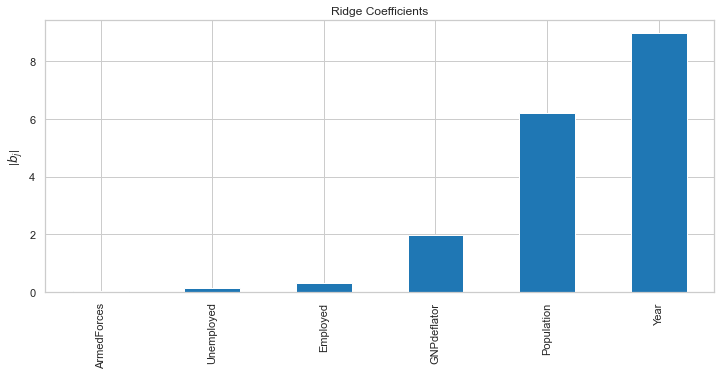

In [31]:
## Ridge Regression
regr_ridge = linear_model.Ridge(alpha=.3) # Create a Ridge regressor
regr_ridge.fit(X, y)  # Perform the fitting

print('Coeff and intercept: {} {}'.format(regr_ridge.coef_,  regr_ridge.intercept_))
coef = pd.Series(np.abs(regr_ridge.coef_[0]),features).sort_values()
coef.plot(kind='bar', title='Ridge Coefficients',ylabel="|$b_j$|")

Coeff and intercept: [ 2.19911646 -0.13035612 -0.02116011  6.90843324  7.62990224  0.        ] [-15512.62771113]


<AxesSubplot:title={'center':'Lasso Coefficients'}, ylabel='|$b_j$|'>

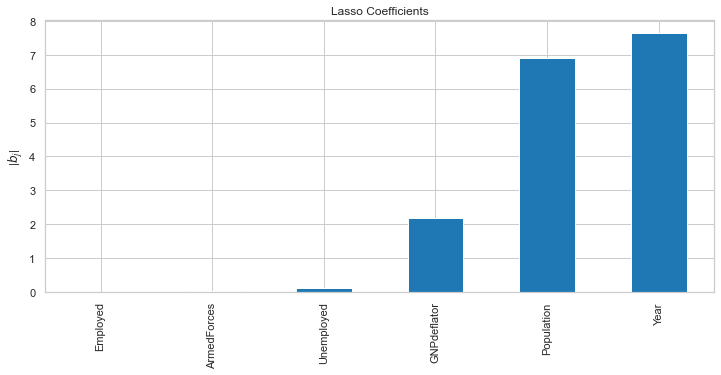

In [32]:
## Lasso Regression
regr_lasso = linear_model.Lasso(alpha=.3,tol=0.001) # Create a Ridge regressor
regr_lasso.fit(X, y)  # Perform the fitting

print('Coeff and intercept: {} {}'.format(regr_lasso.coef_,  regr_lasso.intercept_))

coef = pd.Series(np.abs(regr_lasso.coef_),features).sort_values()
coef.plot(kind='bar', title='Lasso Coefficients',ylabel="|$b_j$|")

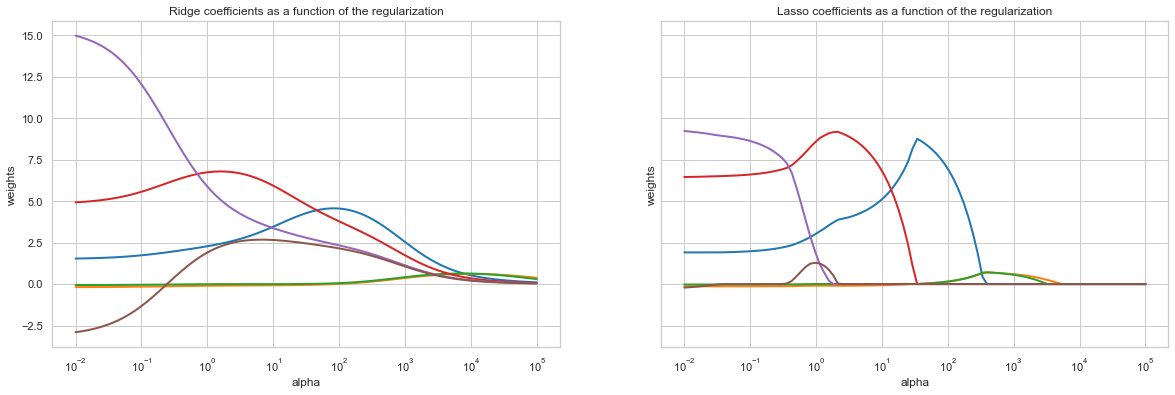

In [33]:
n_alphas = 100
alphas = np.logspace(-2, 5, n_alphas)

coefs_ridge = []

for l in alphas:
    regr_ridge = linear_model.Ridge(alpha=l) # Create a Ridge regressor
    regr_ridge.fit(X, y)  # Perform the fitting
    coefs_ridge.append(regr_ridge.coef_[0])
    
coefs_lasso = []
for l in alphas:
    regr_lasso = linear_model.Lasso(alpha=l,tol =0.001) # Create a Ridge regressor
    regr_lasso.fit(X, y)  # Perform the fitting
    coefs_lasso.append(regr_lasso.coef_)
# #############################################################################
# Display results

fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)


axs[0].plot(alphas, coefs_ridge)
axs[0].set_xscale('log')
axs[0].set_title('Ridge coefficients as a function of the regularization')
axs[0].axis('tight')
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('weights')

axs[1].plot(alphas, coefs_lasso)
axs[1].set_xscale('log')
axs[1].set_title('Lasso coefficients as a function of the regularization')
axs[1].axis('tight')
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('weights')
plt.show()


### EXERCICE: Create and evalualuate a regression model for **THIS** dataset

Remember the ML pipeline: 

#### ML Pipeline
* Setting up the environment and data import
* Understanding the data
* Exploratory Data Analysis
* Linear Regression Model
* Preparation and splitting the data
* Train and Test the Model
* Train and Test New Model
* Compare the models
* Model Performance
* Applying on new data

### STEP 1 - Setting up the enviroment and data import

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
df = pd.read_csv('dataset/regression_healthcare/datasets_13720_18513_insurance.csv')
df['charges'] = np.log(df['charges'])
df.shape

(1338, 7)

In [35]:
df.head()

age     sex     bmi  children smoker     region   charges
0   19  female  27.900         0    yes  southwest  9.734176
1   18    male  33.770         1     no  southeast  7.453302
2   28    male  33.000         3     no  southeast  8.400538
3   33    male  22.705         0     no  northwest  9.998092
4   32    male  28.880         0     no  northwest  8.260197

### Step 2 - Understanding the data

In [36]:
df.head()

age     sex     bmi  children smoker     region   charges
0   19  female  27.900         0    yes  southwest  9.734176
1   18    male  33.770         1     no  southeast  7.453302
2   28    male  33.000         3     no  southeast  8.400538
3   33    male  22.705         0     no  northwest  9.998092
4   32    male  28.880         0     no  northwest  8.260197

In [37]:
df.describe()

age          bmi     children      charges
count  1338.000000  1338.000000  1338.000000  1338.000000
mean     39.207025    30.663397     1.094918     9.098659
std      14.049960     6.098187     1.205493     0.919527
min      18.000000    15.960000     0.000000     7.022756
25%      27.000000    26.296250     0.000000     8.463853
50%      39.000000    30.400000     1.000000     9.146552
75%      51.000000    34.693750     2.000000     9.719558
max      64.000000    53.130000     5.000000    11.063045

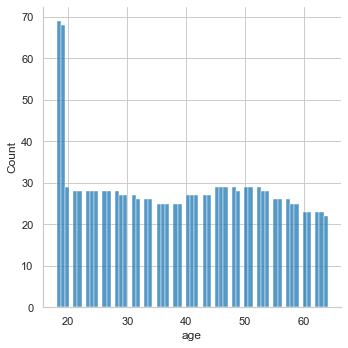

In [38]:
# AGE: Insurance contractor age, year. 
#       min age : 18
#       max age : 64

sns.displot(df.age,bins=65)
plt.show()

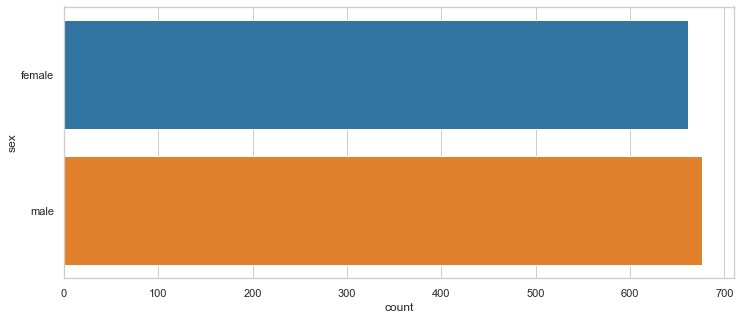

In [39]:
# SEX: Insurance contractor gender, [female, male ]
sns.countplot(data=df, y = 'sex')
plt.show()

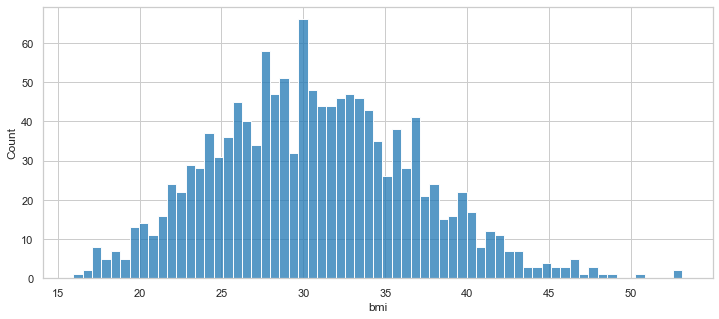

In [40]:
# BMI: Body mass index, providing an understanding of body, weights that are relatively 
# high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of 
# height to weight, ideally 18.5 to 24.9
sns.histplot(df.bmi,bins=65)
plt.show()


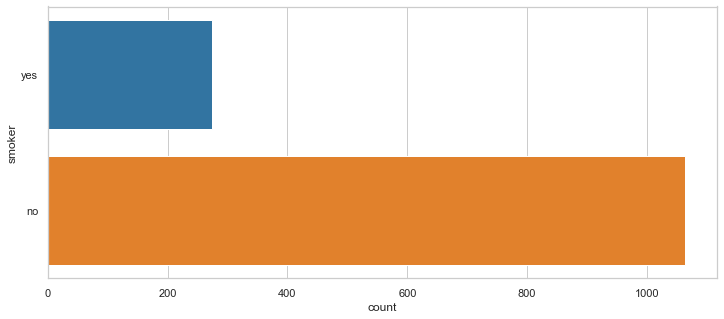

In [41]:
#Smoker: smoking, [yes, no]
sns.countplot(data=df,y='smoker')
plt.show()

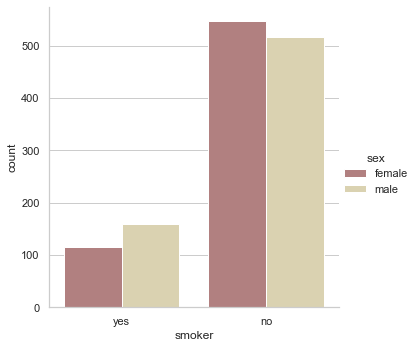

In [42]:
sns.catplot(x="smoker", kind="count",hue = 'sex', palette="pink", data=df)
plt.show()

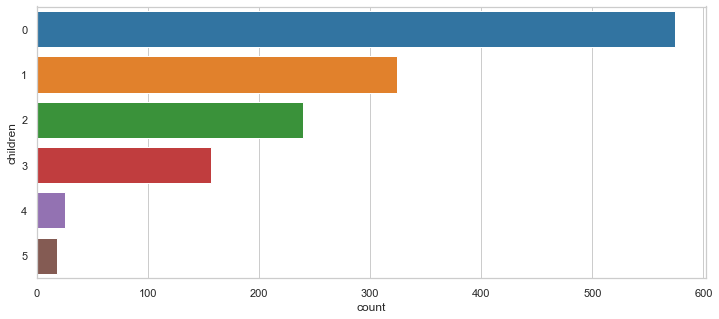

In [43]:
# Children: number of children covered by health insurance / Number of dependents
sns.countplot(data=df,y='children')
plt.show()

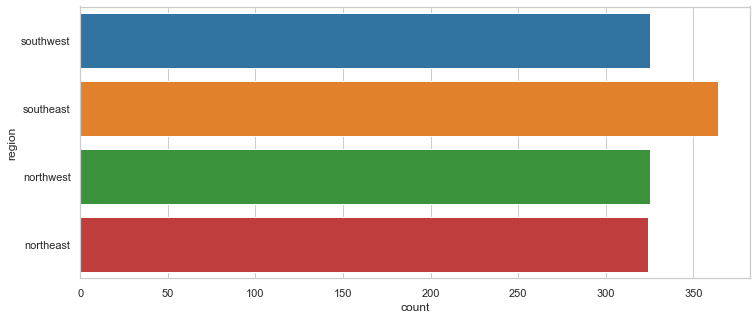

In [44]:
# Children: number of children covered by health insurance / Number of dependents
sns.countplot(data=df,y='region')
plt.show()

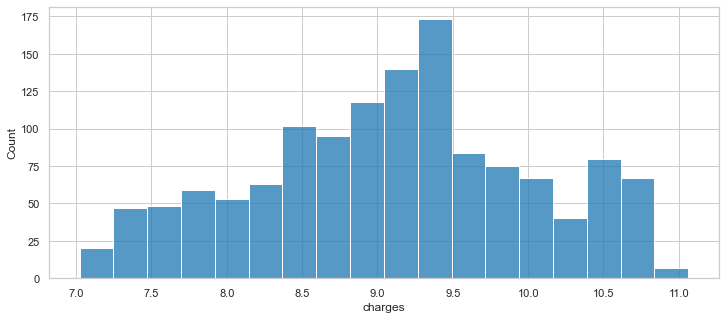

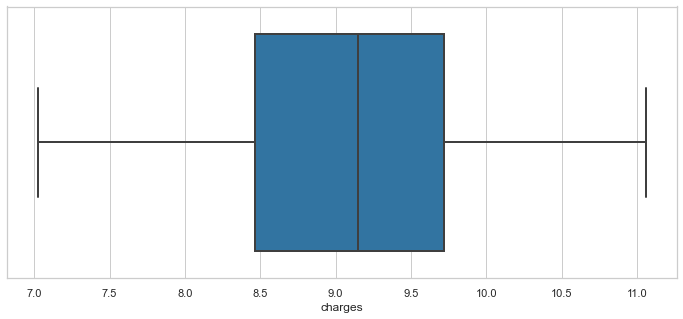

In [45]:
# Charges: Individual medical costs billed by health insurance, $ #predicted value
sns.histplot(df.charges)
plt.show()

sns.boxplot(x=df["charges"])
plt.show()

### Divide data into train and test set

In [46]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.8, random_state=42)

In [47]:
test_set.head()

age     sex     bmi  children smoker     region    charges
764    45  female  25.175         2     no  northeast   9.115488
887    36  female  30.020         0     no  northwest   8.570198
890    64  female  26.885         0    yes  northwest  10.286400
1293   46    male  25.745         3     no  northwest   9.137973
259    19    male  31.920         0    yes  northwest  10.426744

## Prepare the data for Machine Learning algorithms


In [48]:
from sklearn.impute import SimpleImputer
cat_attribs = ['sex','region','smoker']
num_attribs = ['bmi','age','children']

X_num = df[num_attribs]
X_cat = df[cat_attribs]


In [49]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

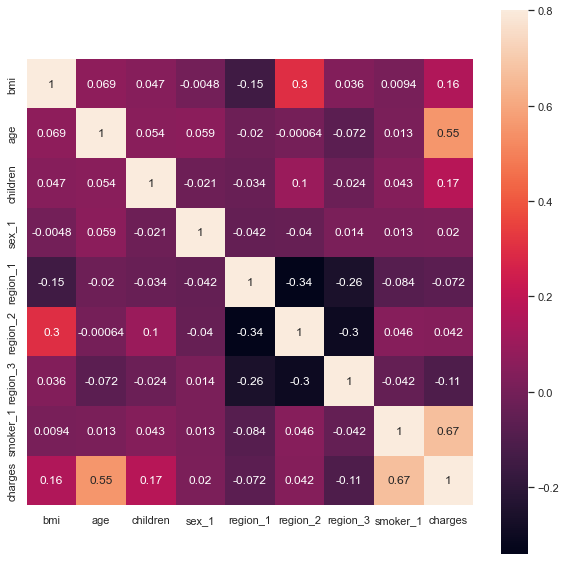

In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(drop='first'), cat_attribs),
    ])
X_train = full_pipeline.fit_transform(train_set)
y_train = train_set['charges']
X_train.shape


tmp = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train.values)], axis=1)
tmp.columns = ['bmi','age','children','sex_1','region_1','region_2','region_3','smoker_1','charges']

corrMatrix = tmp.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corrMatrix, vmax=.8, square=True, annot=True,ax=ax)
plt.show()

## Select and train a model

In [51]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [52]:
# let's try the full preprocessing pipeline on a few training instances
some_data = train_set.iloc[:5]
some_labels = train_set[['charges']].iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predicted Charges:", lin_reg.predict(some_data_prepared))

Predicted Charges: [9.27188411 9.75026019 9.47592498 9.32540787 8.09107125]


In [53]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


y_pred = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, y_pred)
lin_rmse = np.sqrt(lin_mse)
lin_mae = mean_absolute_error(y_train, y_pred)

print(lin_rmse,lin_mae)

0.4506840958185858 0.29877965193996187


### Fine-tune your model


In [54]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


In [55]:
from sklearn.ensemble import RandomForestRegressor


def cross_val_evaluation(model,X_train,y_train,model_name):
    scores = cross_val_score(model, X_train, y_train,cv=5)
    print("\n ",model_name)
    display_scores(scores)

lin_reg = LinearRegression()
cross_val_evaluation(lin_reg,X_train,y_train,'Linear Regression')

ridge_reg = linear_model.Ridge(alpha=.3) # Create a Ridge regressor
cross_val_evaluation(ridge_reg,X_train,y_train,'Ridge Regression')

lasso_reg = linear_model.Lasso(alpha=0.01) # Create a Ridge regressor
cross_val_evaluation(lasso_reg,X_train,y_train,'Lasso Regression')

forest_reg = RandomForestRegressor(random_state=42)
cross_val_evaluation(forest_reg,X_train,y_train,'Random Forest')


  Linear Regression
Scores: [0.70617812 0.72840205 0.80119627 0.75863311 0.74905469]
Mean: 0.7486928467121676
Standard deviation: 0.031858335159009495

  Ridge Regression
Scores: [0.7056062  0.73112462 0.80073289 0.75775965 0.7498124 ]
Mean: 0.7490071518413826
Standard deviation: 0.03148407311948673

  Lasso Regression
Scores: [0.69793144 0.74926457 0.79870914 0.76427246 0.74161457]
Mean: 0.750358437336406
Standard deviation: 0.032734179587881856

  Random Forest
Scores: [0.64184629 0.76978049 0.77833358 0.83648851 0.73843317]
Mean: 0.7529764069791554
Standard deviation: 0.06397037555553352


In [56]:
# Random forest obtains the best result with a R^2 = 0.753
# The second best model is Lasso with a R^2 = 0.7503

Let's try to find get the best model of Ridge 

In [57]:
from sklearn.model_selection import GridSearchCV

#the set of parameters to try
param_grid = [{'alpha': np.logspace(-2, 5, 100)}]

ridge_reg = linear_model.Ridge() # Create a Ridge regressor
grid_search_ridge = GridSearchCV(ridge_reg, param_grid, cv=5,#scoring="neg_mean_squared_error",
                                 return_train_score=True)

grid_search_ridge.fit(X_train, y_train)
print("The best model was found with = ",grid_search_ridge.best_params_)
print(grid_search_ridge.best_score_)
pd.DataFrame(grid_search_ridge.cv_results_)

The best model was found with =  {'alpha': 1.3219411484660286}
0.7494507772096801


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.000756      0.000246         0.000266    2.107135e-05   
1        0.000513      0.000034         0.000247    2.683030e-06   
2        0.000484      0.000003         0.000244    1.112166e-06   
3        0.000488      0.000009         0.000245    1.124365e-06   
4        0.000481      0.000004         0.000245    2.471286e-06   
..            ...           ...              ...             ...   
95       0.000494      0.000025         0.000247    6.563400e-06   
96       0.000495      0.000019         0.000248    6.526924e-06   
97       0.000470      0.000002         0.000238    1.549537e-06   
98       0.000467      0.000003         0.000237    8.609519e-07   
99       0.000474      0.000016         0.000237    9.608003e-07   

     param_alpha                           params  split0_test_score  \
0           0.01                  {'alpha': 0.01}           0.706160   
1       0.011768  {'alpha': 0.011768119524349984}           0.706157   
2       0.013849  {'alpha': 0.013848863713938732}           0.706154   
3       0.016298  {'alpha': 0.016297508346206444}           0.706149   
4       0.019179  {'alpha': 0.019179102616724886}           0.706144   
..           ...                              ...                ...   
95   52140.08288    {'alpha': 52140.082879996844}          -0.032544   
96  61359.072734     {'alpha': 61359.07273413163}          -0.032980   
97  72208.090184     {'alpha': 72208.09018385457}          -0.033351   
98  84975.343591     {'alpha': 84975.34359086439}          -0.033667   
99      100000.0              {'alpha': 100000.0}          -0.033936   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.728496           0.801182           0.758605   
1            0.728512           0.801179           0.758599   
2            0.728532           0.801176           0.758593   
3            0.728555           0.801173           0.758586   
4            0.728582           0.801168           0.758578   
..                ...                ...                ...   
95          -0.014863          -0.011233          -0.010803   
96          -0.015407          -0.011771          -0.011335   
97          -0.015870          -0.012228          -0.011788   
98          -0.016264          -0.012618          -0.012173   
99          -0.016599          -0.012949          -0.012501   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  \
0            0.749081         0.748705        0.031845               35   
1            0.749086         0.748707        0.031842               34   
2            0.749091         0.748709        0.031839               33   
3            0.749098         0.748712        0.031836               32   
4            0.749106         0.748716        0.031832               31   
..                ...              ...             ...              ...   
95          -0.002747        -0.014438        0.009881               96   
96          -0.003303        -0.014959        0.009840               97   
97          -0.003776        -0.015403        0.009805               98   
98          -0.004178        -0.015780        0.009775               99   
99          -0.004521        -0.016101        0.009750              100   

    split0_train_score  split1_train_score  split2_train_score  \
0             0.782109            0.777806            0.762233   
1             0.782109            0.777806            0.762233   
2             0.782109            0.777806            0.762233   
3             0.782109            0.777806            0.762233   
4             0.782109            0.777806            0.762233   
..                 ...                 ...                 ...   
95            0.003936            0.003447            0.003555   
96            0.003347            0.002932            0.003023   
97            0.002846            0.002493            0.002571   
98  

In [58]:
# before 
ridge_reg = linear_model.Ridge(alpha=.3) # Create a Ridge regressor
cross_val_evaluation(ridge_reg,X_train,y_train,'Ridge Regression')
# after
ridge_reg = linear_model.Ridge(alpha=1.3219411484660286) # Create a Ridge regressor
cross_val_evaluation(ridge_reg,X_train,y_train,'Ridge Regression')


  Ridge Regression
Scores: [0.7056062  0.73112462 0.80073289 0.75775965 0.7498124 ]
Mean: 0.7490071518413826
Standard deviation: 0.03148407311948673

  Ridge Regression
Scores: [0.70304511 0.73906905 0.79875652 0.75457115 0.75181206]
Mean: 0.7494507772096801
Standard deviation: 0.030737977754228808


In [59]:
lasso_reg = linear_model.Lasso(tol=0.01) # Create a Ridge regressor
grid_search_lasso = GridSearchCV(lasso_reg, param_grid, cv=5,#scoring="neg_root_mean_squared_error",
                                 return_train_score=True)
grid_search_lasso.fit(X_train, y_train)
print(grid_search_lasso.best_params_)
print(grid_search_lasso.best_score_)

pd.DataFrame(grid_search_lasso.cv_results_)

{'alpha': 0.013848863713938732}
0.7509449981475373


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.001140  2.160387e-04         0.000424        0.000096   
1        0.000716  1.728478e-04         0.000303        0.000061   
2        0.000490  2.899327e-05         0.000245        0.000006   
3        0.000469  2.381323e-06         0.000243        0.000005   
4        0.000558  6.069626e-05         0.000288        0.000024   
..            ...           ...              ...             ...   
95       0.000481  2.423365e-05         0.000276        0.000048   
96       0.000488  2.223156e-05         0.000249        0.000002   
97       0.000479  4.101908e-07         0.000248        0.000001   
98       0.000482  2.078485e-06         0.000248        0.000001   
99       0.000479  2.223309e-06         0.000254        0.000013   

     param_alpha                           params  split0_test_score  \
0           0.01                  {'alpha': 0.01}           0.697952   
1       0.011768  {'alpha': 0.011768119524349984}           0.697635   
2       0.013849  {'alpha': 0.013848863713938732}           0.697093   
3       0.016298  {'alpha': 0.016297508346206444}           0.696222   
4       0.019179  {'alpha': 0.019179102616724886}           0.695201   
..           ...                              ...                ...   
95   52140.08288    {'alpha': 52140.082879996844}          -0.035462   
96  61359.072734     {'alpha': 61359.07273413163}          -0.035462   
97  72208.090184     {'alpha': 72208.09018385457}          -0.035462   
98  84975.343591     {'alpha': 84975.34359086439}          -0.035462   
99      100000.0              {'alpha': 100000.0}          -0.035462   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.749143           0.798792           0.764323   
1            0.751842           0.797422           0.764768   
2            0.754654           0.795557           0.765036   
3            0.757441           0.793176           0.765000   
4            0.760373           0.790480           0.764244   
..                ...                ...                ...   
95          -0.018501          -0.014829          -0.014361   
96          -0.018501          -0.014829          -0.014361   
97          -0.018501          -0.014829          -0.014361   
98          -0.018501          -0.014829          -0.014361   
99          -0.018501          -0.014829          -0.014361   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  \
0            0.741555         0.750353        0.032760                5   
1            0.741984         0.750730        0.032478                3   
2            0.742384         0.750945        0.032174                1   
3            0.742745         0.750917        0.031891                2   
4            0.743016         0.750663        0.031619                4   
..                ...              ...             ...              ...   
95          -0.006464        -0.017923        0.009607               26   
96          -0.006464        -0.017923        0.009607               26   
97          -0.006464        -0.017923        0.009607               26   
98          -0.006464        -0.017923        0.009607               26   
99          -0.006464        -0.017923        0.009607               26   

    split0_train_score  split1_train_score  split2_train_score  \
0             0.779866            0.773279            0.758058   
1             0.779214            0.771973            0.756815   
2             0.778309            0.770167            0.755124   
3             0.777057            0.767676            0.753528   
4             0.775807            0.765309            0.751923   
..                 ...                 ...                 ...   
95            0.000000            0.000000            0.000000   
96            0.000000            0.000000            0.000000   
97            0.000000            0.000000            0.000000   
98  

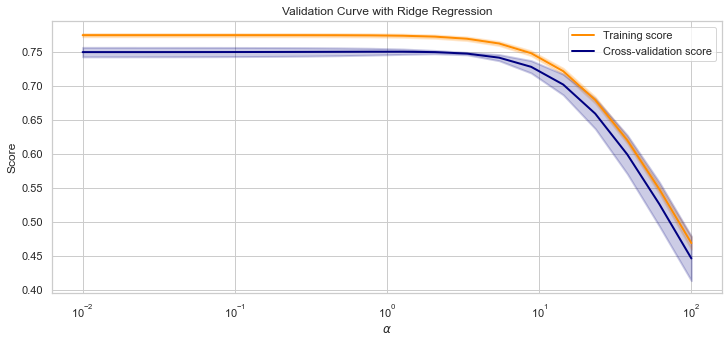

In [60]:
#let's plot the accuracy on training and test 

from sklearn.model_selection import validation_curve
param_range= np.logspace(-2, 2, 20)

train_scores, valid_scores = validation_curve(ridge_reg, X_train, y_train, param_name= "alpha",
                                              param_range= param_range,
                                              cv=3)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)


plt.title("Validation Curve with Ridge Regression")
plt.xlabel(r"$\alpha$")
plt.ylabel("Score")

lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

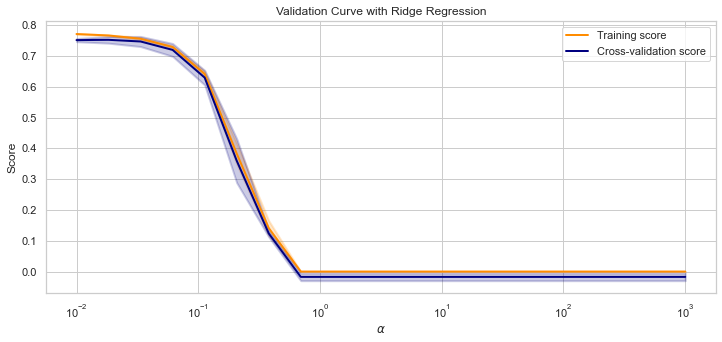

In [61]:
# The same with lasso model
param_range= np.logspace(-2, 3, 20)

train_scores, valid_scores = validation_curve(lasso_reg, X_train, y_train, param_name= "alpha",
                                              param_range= param_range,
                                              cv=3)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)


plt.title("Validation Curve with Ridge Regression")
plt.xlabel(r"$\alpha$")
plt.ylabel("Score")

lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

### Evaluate test set

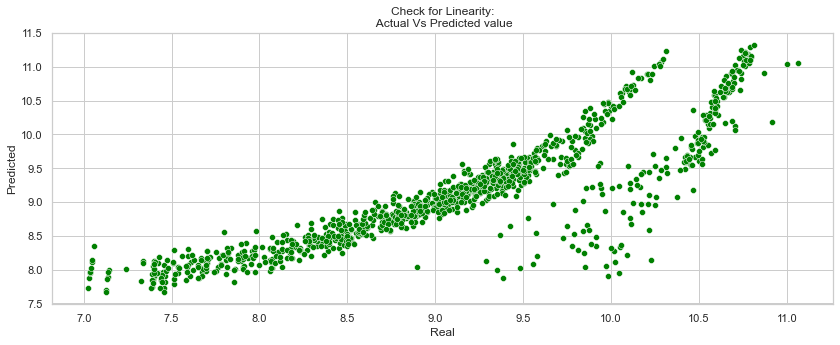

In [62]:
# Check for Linearity
X_test = full_pipeline.transform(test_set)
y_test = test_set['charges']

lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)

plt.figure(figsize=(14,5))
sns.scatterplot(x = y_test,y = y_pred,color='g')
plt.title('Check for Linearity:\n Actual Vs Predicted value')
plt.ylabel('Predicted')
plt.xlabel('Real')

plt.show()

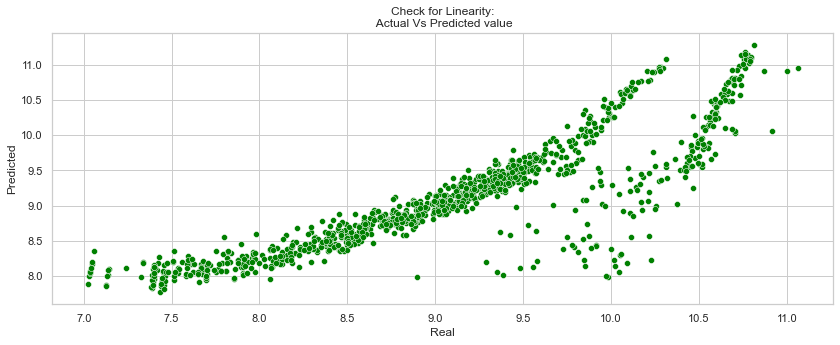

In [63]:
# Check for Linearity --  LASSSO
X_test = full_pipeline.transform(test_set)
y_test = test_set['charges']

y_pred = grid_search_lasso.predict(X_test)

plt.figure(figsize=(14,5))
sns.scatterplot(x = y_test,y = y_pred,color='g')
plt.title('Check for Linearity:\n Actual Vs Predicted value')
plt.ylabel('Predicted')
plt.xlabel('Real')

plt.show()

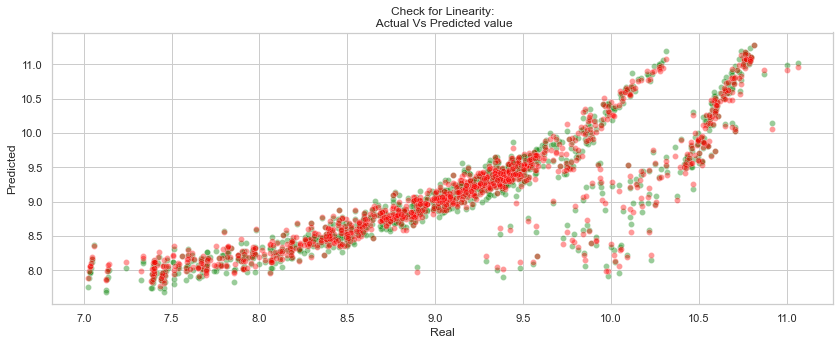

In [64]:
# Check for Linearity --  RIGE
X_test = full_pipeline.transform(test_set)
y_test = test_set['charges']

grid_search_lasso.fit(X_train,y_train)
y_pred_lasso = grid_search_lasso.predict(X_test)

y_pred_ridge = grid_search_ridge.predict(X_test)


plt.figure(figsize=(14,5))
sns.scatterplot(x = y_test, y = y_pred_ridge,color='g',alpha=0.4)
sns.scatterplot(x = y_test, y = y_pred_lasso,color='r',alpha=0.4)

plt.title('Check for Linearity:\n Actual Vs Predicted value')
plt.ylabel('Predicted')
plt.xlabel('Real')

plt.show()

In [65]:
print("LINEAR REGRESSION")
y_pred = lin_reg.predict(X_test)
# The mean squared error
print(' Mean squared error: %.3f'%  np.sqrt(mean_squared_error(y_test, y_pred)))
# The coefficient of determination: 1 is perfect prediction
print(' Coefficient of determination (R^2): %.3f'% r2_score(y_test, y_pred))

print("\nRIDGE REGRESSION")
print(grid_search_ridge.best_params_)
y_pred = grid_search_ridge.predict(X_test)
# The mean squared error
print(' Mean squared error: %.3f'%  np.sqrt(mean_squared_error(y_test, y_pred)))
# The coefficient of determination: 1 is perfect prediction
print(' Coefficient of determination (R^2): %.3f'% r2_score(y_test, y_pred))


print("\nLASSO REGRESSION")
print(grid_search_lasso.best_params_)
y_pred = grid_search_lasso.predict(X_test)
# The mean squared error
print(' Mean squared error: %.3f'%  np.sqrt(mean_squared_error(y_test, y_pred)))
# The coefficient of determination: 1 is perfect prediction
print(' Coefficient of determination (R^2): %.3f'% r2_score(y_test, y_pred))

LINEAR REGRESSION
 Mean squared error: 0.445
 Coefficient of determination (R^2): 0.762

RIDGE REGRESSION
{'alpha': 1.3219411484660286}
 Mean squared error: 0.446
 Coefficient of determination (R^2): 0.762

LASSO REGRESSION
{'alpha': 0.013848863713938732}
 Mean squared error: 0.450
 Coefficient of determination (R^2): 0.757


In [66]:
## QUESTION: What happens if in the problem of House Prediction Price instead of estimating the price, we estimate the log of the price?